Found 945 images belonging to 2 classes.
Found 146 images belonging to 2 classes.
Epoch 1/15
60/60 [==============================] - 8s 64ms/step - loss: 0.7884 - accuracy: 0.5122 - val_loss: 0.7012 - val_accuracy: 0.5411
Epoch 2/15
60/60 [==============================] - 3s 49ms/step - loss: 0.6610 - accuracy: 0.6042 - val_loss: 0.6680 - val_accuracy: 0.6027
Epoch 3/15
60/60 [==============================] - 3s 48ms/step - loss: 0.6481 - accuracy: 0.6413 - val_loss: 0.6523 - val_accuracy: 0.6233
Epoch 4/15
60/60 [==============================] - 3s 48ms/step - loss: 0.5935 - accuracy: 0.6942 - val_loss: 0.6314 - val_accuracy: 0.6575
Epoch 5/15
60/60 [==============================] - 3s 50ms/step - loss: 0.5725 - accuracy: 0.6974 - val_loss: 0.6333 - val_accuracy: 0.6438
Epoch 6/15
60/60 [==============================] - 3s 48ms/step - loss: 0.5637 - accuracy: 0.7058 - val_loss: 0.6213 - val_accuracy: 0.6781
Epoch 7/15
60/60 [==============================] - 3s 47ms/step - loss:

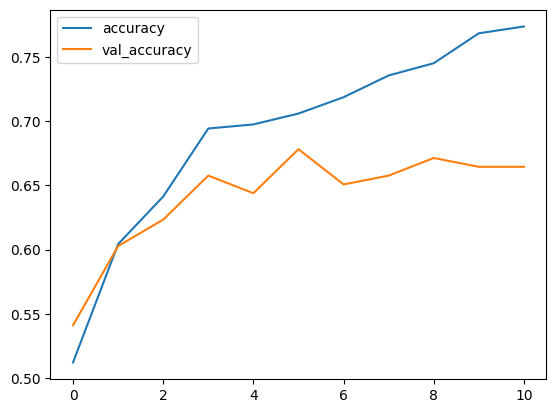

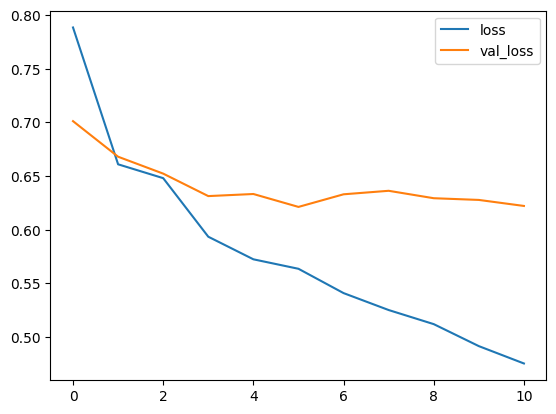

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import glob
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import seaborn as sns
import pandas as pd

def create_resnet_model():
    base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.2),  # Ajuste para manter consistência
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])

    return model

def plot_metrics(history):
    df = pd.DataFrame(history.history)
    df[['accuracy', 'val_accuracy']].plot()
    plt.show()
    df[['loss', 'val_loss']].plot()
    plt.show()

def save_classification_report(filename, report):
    with open(filename, 'w') as file:
        file.write(f'tempo {report}')

def plot_confusion_matrix(cm, labels):
    cm_df = pd.DataFrame(cm, columns=labels, index=labels)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm_df, annot=True)
    plt.show()

def main():
    NAME = f"Tcc_cnn_64_{int(time.time())}"

    all_training_paths = glob.glob('DATASETS/TRAINING/*/*.jpg')
    all_validation_paths = glob.glob('DATASETS/VALIDATION/*/*.jpg')

    datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_gen = datagen_resnet.flow_from_directory('DATASETS/TRAINING/',
                                                   target_size=(224, 224),
                                                   class_mode="categorical",
                                                   batch_size=16
                                                   )

    validation_gen = datagen_resnet.flow_from_directory('DATASETS/VALIDATION/',
                                                        target_size=(224, 224),
                                                        class_mode="categorical",
                                                        batch_size=16
                                                        )

 

    # Configurar o ModelCheckpoint
       # Configurar o ModelCheckpoint com o número da época no nome do arquivo
    checkpoint = ModelCheckpoint('best_model_epoch_{epoch:02d}.h5', 
                                 monitor='val_accuracy', 
                                 save_best_only=True, 
                                 mode='max'
                                )
    
        # Configurar o EarlyStopping para interromper o treinamento se não houver melhoria na métrica monitorada
    early_stopping = EarlyStopping(monitor='val_accuracy', 
                                   patience=5,  # Número de épocas sem melhoria antes de parar
                                   restore_best_weights=True
                                  )
    
    tensor_board = TensorBoard(log_dir=f'logs/{NAME}')

    model = create_resnet_model()

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                  )

    history = model.fit(train_gen,
                        validation_data=validation_gen,
                        epochs=15,
                        batch_size=16,
                        callbacks=[tensor_board, checkpoint, early_stopping]
                        )

    plot_metrics(history)
    
    

if __name__ == "__main__":
    main()
    


Found 464 images belonging to 2 classes.
29/29 [==============================] - 2s 36ms/step
[[134 100]
 [122 108]]
              precision    recall  f1-score   support

           0       0.52      0.57      0.55       234
           1       0.52      0.47      0.49       230

    accuracy                           0.52       464
   macro avg       0.52      0.52      0.52       464
weighted avg       0.52      0.52      0.52       464



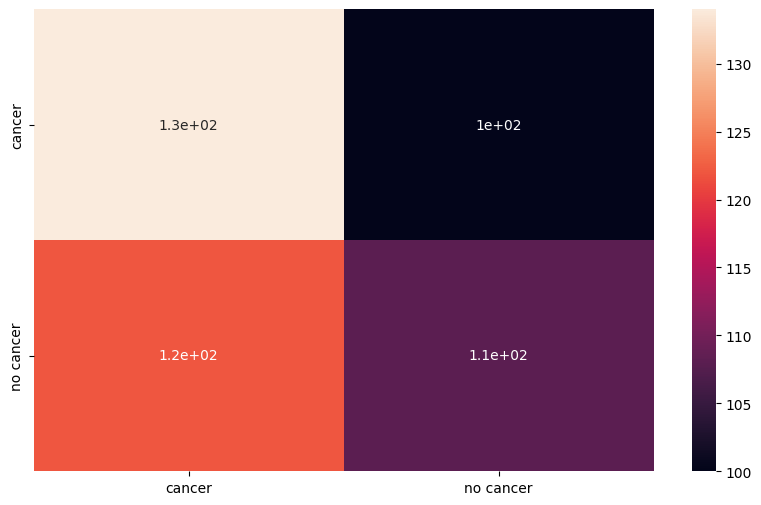

Verdadeiro Positivo (TP): 108
Verdadeiro Negativo (TN): 134
Falso Positivo (FP): 100
Falso Negativo (FN): 122


In [2]:


datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = datagen_resnet.flow_from_directory('DATASETS/TESTING/',
                                                  target_size=(224, 224),
                                                  class_mode="categorical",
                                                  batch_size=16
                                                  )

#Após o treinamento, você pode carregar o melhor modelo salvo usando:
best_model = tf.keras.models.load_model('best_model_epoch_05.h5')

predictions = best_model.predict(test_gen, verbose=1)

y_pred = np.argmax(predictions, axis=-1)
y_test = test_gen.labels

cm = confusion_matrix(y_test, y_pred)
print(cm)

classification_rep = classification_report(test_gen.classes, y_pred)
print(classification_rep)

save_classification_report('time_bin_metrics.txt', classification_rep)

plot_confusion_matrix(cm, ['cancer', 'no cancer'])
    
     # A matriz de confusão foi calculada durante a execução do main()
cm = confusion_matrix(y_test, y_pred)

    # Interpretando a matriz de confusão
TP = cm[1, 1]  # Verdadeiro Positivo
TN = cm[0, 0]  # Verdadeiro Negativo
FP = cm[0, 1]  # Falso Positivo
FN = cm[1, 0]  # Falso Negativo

print(f"Verdadeiro Positivo (TP): {TP}")
print(f"Verdadeiro Negativo (TN): {TN}")
print(f"Falso Positivo (FP): {FP}")
print(f"Falso Negativo (FN): {FN}")

In [6]:
modelo_op = tf.keras.models.load_model('models/best_model_epoch.h5')
predictions = modelo_op.predict(test_gen, verbose=1)

29/29 [==============================] - 37s 1s/step


In [7]:
def predicao(modelo, path):
    image = Image.open(path)

# Redimensione a imagem
    resized_image = image.resize((224, 224))

    # Certifique-se de que a imagem seja colorida (3 canais)
    if resized_image.mode == 'L':
        # Converta a imagem em escala de cinza em uma imagem RGB (colorida)
        resized_image = resized_image.convert('RGB')

    # Converta a imagem redimensionada em uma matriz NumPy
    np_array = np.array(resized_image)

    
    img_np = preprocess_input(np_array)
    imp_np2=img_np.reshape(1,224,224,3)
    result = modelo_op.predict(imp_np2)
    id_max= result[0].argmax()
    index_to_class = {v: k for k, v in test_gen.class_indices.items()}
    plt.title(f'Resultado: {index_to_class[id_max]}')
    plt.imshow(resized_image)
    plt.show()

DATASETS/TESTING\WITHOUT-CANCER\2-101.jpg
1/1 [==============================] - 1s 588ms/step


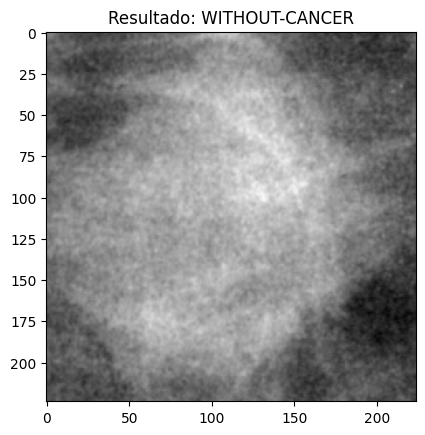

DATASETS/TESTING\WITHOUT-CANCER\1-277.jpg
1/1 [==============================] - 0s 21ms/step


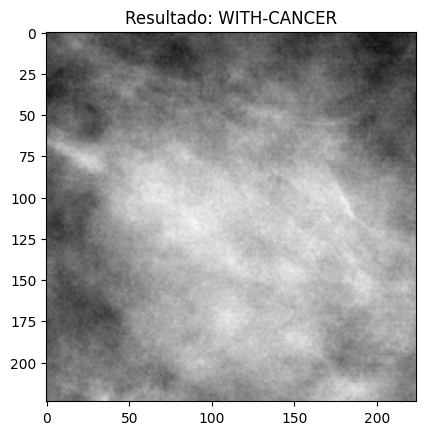

DATASETS/TESTING\WITHOUT-CANCER\2-062.jpg
1/1 [==============================] - 0s 28ms/step


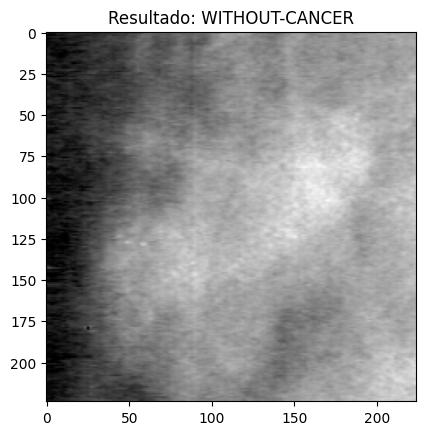

DATASETS/TESTING\WITH-CANCER\2-216.jpg
1/1 [==============================] - 0s 22ms/step


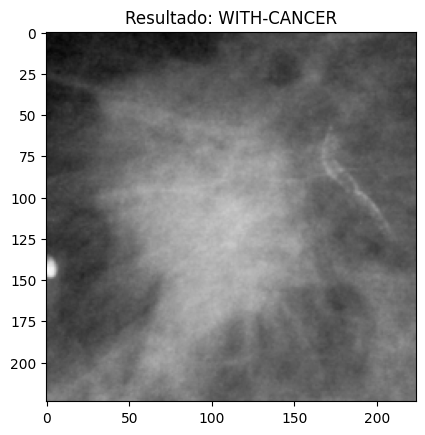

DATASETS/TESTING\WITHOUT-CANCER\1-276.jpg
1/1 [==============================] - 0s 24ms/step


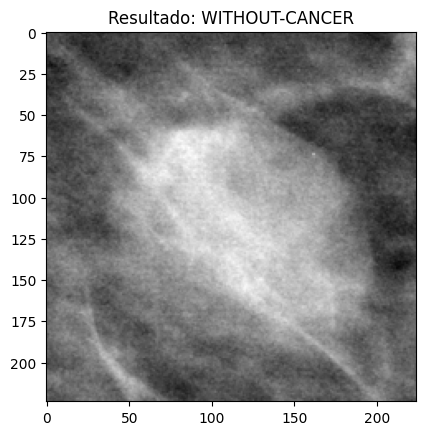

DATASETS/TESTING\WITHOUT-CANCER\2-181.jpg
1/1 [==============================] - 0s 21ms/step


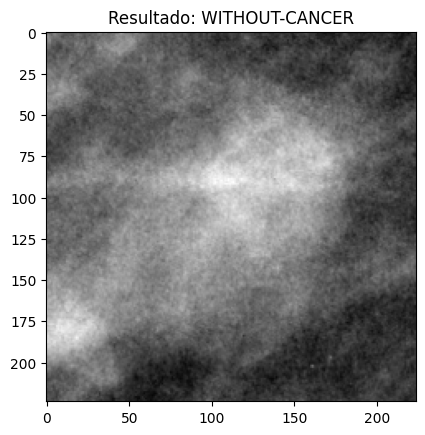

DATASETS/TESTING\WITH-CANCER\2-208.jpg
1/1 [==============================] - 0s 22ms/step


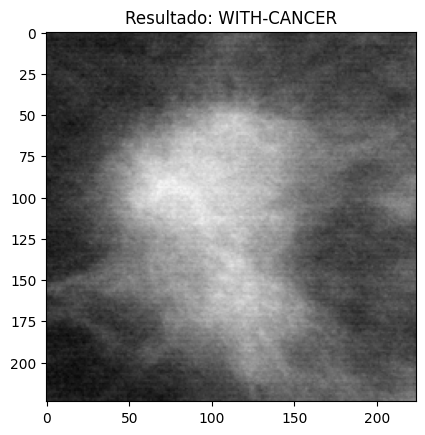

DATASETS/TESTING\WITH-CANCER\2-154.jpg
1/1 [==============================] - 0s 21ms/step


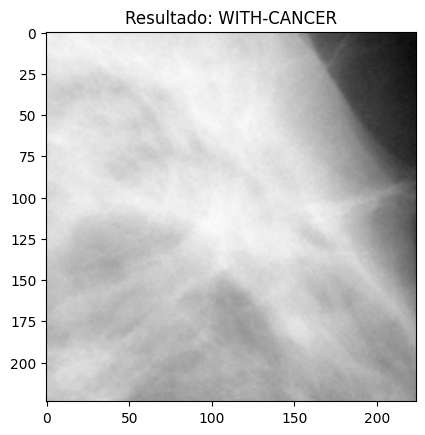

In [8]:
import random
# pegando 10 cminhos aliatorios para predição e moreando o resultado
all_test_paths = glob.glob('DATASETS/TESTING/*/*.jpg')
for i in range(8):
    img_path=random.choice(all_test_paths)
    print(img_path)
    predicao(modelo_op, img_path)